# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import cv2
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import ShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import Subset
import torchvision.transforms.functional as tf
import torch.optim as optim
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
np.random.seed(42)
torch.manual_seed(42)

In [3]:
data=pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
data.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
def bbox_ops(string):
    ls=string.split()
    bbox=[]
    for i in range(4):
        bbox.append(np.float32(ls[i].strip("[],")))
        
    return bbox

In [5]:
data["bbox"]=data["bbox"].apply(bbox_ops)

data["x0"]=data["bbox"].apply(lambda x:x[0])
data["y0"]=data["bbox"].apply(lambda x:x[1])
data["w"]=data["bbox"].apply(lambda x:x[2])
data["h"]=data["bbox"].apply(lambda x:x[3])

data.drop(columns=["bbox","source"],axis=1,inplace=True)
data.head()

,image_id,width,height,x0,y0,w,h
0,b6ab77fd7,1024,1024,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,26.0,144.0,124.0,117.0


In [6]:
data["image_id"].nunique()

3373

# Configuration

In [7]:
dataframe=data
image_dir="/kaggle/input/global-wheat-detection/train"
test_dir="/kaggle/input/global-wheat-detection/test"
model_weights_file="model.pth"

device="cuda" if torch.cuda.is_available() else "cpu"

batch_size=4
learning_rate=3e-5
epochs=50

threshold=0.5
iou_threshold=0.8

# Custom Dataset

In [8]:
"""The input to the model is expected to be a list of tensors, each of shape [C, H, W], 
   one for each image, and should be in 0-1 range. Different images can have different 
   sizes.The behavior of the model changes depending if it is in training or evaluation 
   mode."""

class WheatDataset(Dataset):
    def __init__(self,dataframe,image_dir):
        super().__init__()
        self.dataframe=dataframe
        self.img_list=sorted(self.dataframe["image_id"].unique())
        self.img_dir=image_dir
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img_name=self.img_list[idx]+".jpg"
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=tf.to_tensor(img)
        
        inter=self.dataframe[self.dataframe["image_id"]==self.img_list[idx]]
        boxes=inter[["x0","y0","w","h"]].values
        area=boxes[:,2]*boxes[:,3]
        
        # converting bounding box from x0y0wh format to x0y0x1y1 format
        boxes[:,2]=boxes[:,0]+boxes[:,2]
        boxes[:,3]=boxes[:,1]+boxes[:,3]
        
        labels=torch.ones((boxes.shape[0]),dtype=torch.int64)
        iscrowd=torch.zeros((boxes.shape[0]),dtype=torch.uint8)
        
        target={}
        target["boxes"]=torch.as_tensor(boxes,dtype=torch.float32)
        target["area"]=torch.as_tensor(area,dtype=torch.float32)
        target["labels"]=labels
        target["iscrowd"]=iscrowd
        target["id"]=torch.tensor(idx)
        
        return img,target

In [9]:
train_ds=WheatDataset(dataframe,image_dir)
val_ds=WheatDataset(dataframe,image_dir)

In [10]:
ss=ShuffleSplit(n_splits=1,test_size=0.2,random_state=1)

indexs=range(len(train_ds))
for train_idx,val_idx in ss.split(indexs):
    print(f"Train dataset length: {len(train_idx)}")
    print(f"Validation dataset length: {len(val_idx)}")

Train dataset length: 2698
Validation dataset length: 675


In [11]:
train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

# Data Visualization

In [12]:
def show(img,boxes):
    boxes=boxes.detach().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()
    
    for box in boxes:
        cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(220, 0, 0), 3)
    
    plt.axis("off");
    plt.imshow(sample);

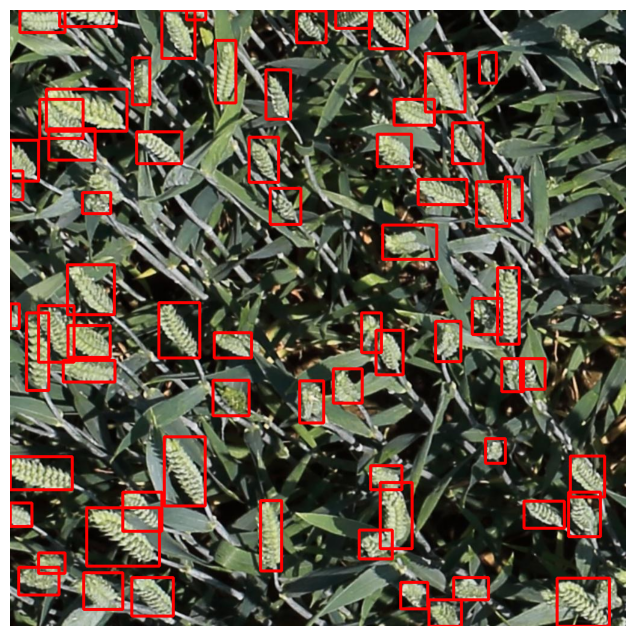

In [13]:
plt.figure(figsize=(8,8))

img,target=next(iter(train_ds))
show(img,target["boxes"])
plt.savefig("1.png")

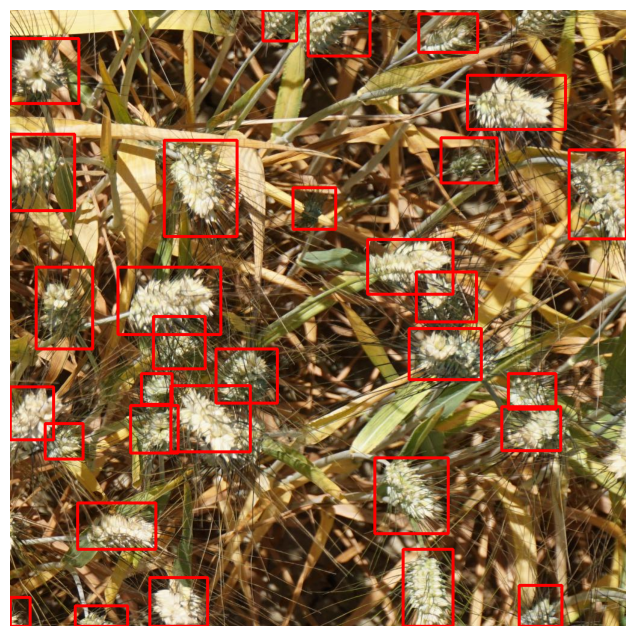

In [14]:
plt.figure(figsize=(8,8))

img,target=next(iter(val_ds))
show(img,target["boxes"])
plt.savefig("2.png")

# DataLoader

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=2,
                    pin_memory=True if torch.cuda.is_available else False,
                    collate_fn=collate_fn)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=2,
                  pin_memory=True if torch.cuda.is_available else False,
                  collate_fn=collate_fn)

# Model

In [17]:
# load a model pre-trained on COCO
weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model=fasterrcnn_resnet50_fpn(weights=weights)

# replace the classifier with a new one, that has
# num_classes which is user-defined
# 1 class (person) + background
num_classes = 2 

# get number of input features for the classifier
in_features=model.roi_heads.box_predictor.cls_score.in_features


# replace the pre-trained head with a new one
model.roi_heads.box_predictor=FastRCNNPredictor(in_channels=in_features, 
                                                num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 157MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [18]:
for params in model.children():
    print(params)

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)
BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [19]:
"""ConvNet as fixed feature extractor: Here, we will freeze the weights for the backbone of
   the network (resnet50 with feature pyramid network). The Regional Proposal network and 
   Region of Interest heads will be fine tuned using transfer learning."""

classification_head=list(model.children())[-2:]

for children in list(model.children())[:-2]:
    for params in children.parameters():
        params.requires_grad=False
        
parameters=[]
for heads in classification_head:
    for params in heads.parameters():
        parameters.append(params)
        

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=8, threshold=0.0001)

        
print(classification_head)

[RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
), RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)]


# Training

In [20]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [21]:
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    
    training_loss=0.0
    validation_loss=0.0
    current_lr=get_lr(optimizer)
    
    #During training, the model expects both the input tensors, as well as a targets 
    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        
        """The model returns a Dict[Tensor] during training, containing the classification
           and regression losses for both the RPN and the R-CNN."""
        
        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            
            """The model returns a Dict[Tensor] during training, containing the classification
               and regression losses for both the RPN and the R-CNN."""
            
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
            
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
            
    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

Updating Best Model weights

1/50
Training Loss: 0.33299900709566493
Validation_loss: 0.29344729547147397

**************************************************
Updating Best Model weights

2/50
Training Loss: 0.2891622898400139
Validation_loss: 0.28333730512195165

**************************************************
Updating Best Model weights

3/50
Training Loss: 0.279798388459048
Validation_loss: 0.2776091445816888

**************************************************
Updating Best Model weights

4/50
Training Loss: 0.2727308876210447
Validation_loss: 0.27322495698928834

**************************************************

5/50
Training Loss: 0.26844553962029555
Validation_loss: 0.27370115598042805

**************************************************
Updating Best Model weights

6/50
Training Loss: 0.2645622300739373
Validation_loss: 0.26610795745143184

**************************************************
Updating Best Model weights

7/50
Training Loss: 0.26068321005161643
Validation_loss: 

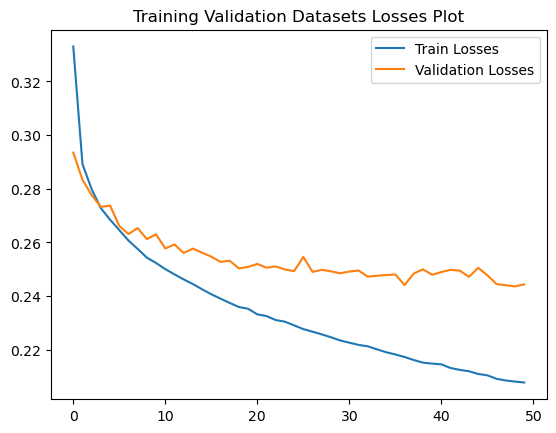

In [22]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();
plt.savefig("3.jpg")

# Saving Model State

In [23]:
torch.save(best_weights,model_weights_file)

# Inference

In [24]:
model.load_state_dict(torch.load(model_weights_file))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [25]:
def show(img,boxes,ax,color=(255,0,0)):
    boxes=boxes.detach().cpu().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()
    
    for box in boxes:
        cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),color, 3)
    
    ax.axis("off");
    ax.imshow(sample);

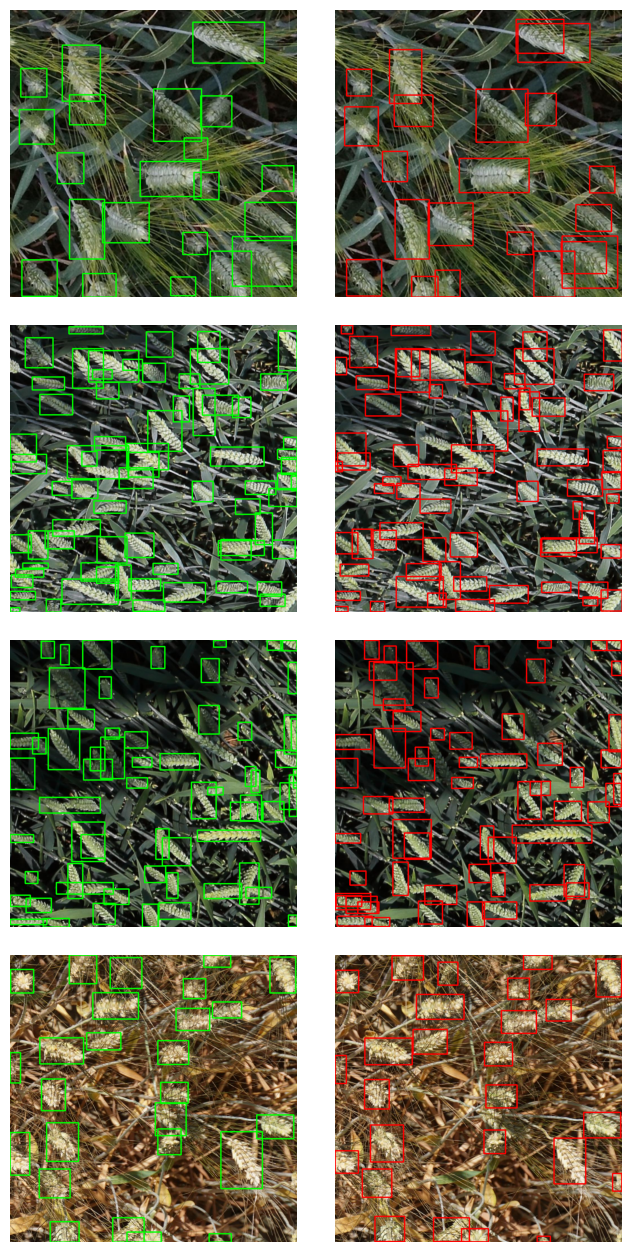

In [26]:
"""During inference, the model requires only the input tensors, and returns the 
   post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields
   of the Dict are as follows:
   - boxes (FloatTensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format
   - labels (Int64Tensor[N]): the predicted labels for each image
   - scores (Tensor[N]): the scores or each prediction"""

fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(train_dl))
model.eval()
output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    predictions=output[idx]
    
    #real bounding boxes
    show(img,targets[idx]["boxes"],axes[i,0],color=(0,255,0))
    
    #non-max suppression
    #threshold=0.5
    #iou_threshold=0.8
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    pp_boxes=predictions["boxes"][predictions["scores"]>=threshold]
    scores=predictions["scores"][predictions["scores"]>=threshold]
    nms=torchvision.ops.nms(pp_boxes,scores,iou_threshold=iou_threshold)
    pp_boxes=pp_boxes[nms]

    
    show(img,pp_boxes,axes[i,1]);
    
plt.savefig("4.png")